```bash
sudo apt install cmake build-essential
git clone git@github.com:glyg/cgal4py.git
sudo apt install libeigen3-dev libboost-dev libghc-opengl-dev
wget https://github.com/CGAL/cgal/releases/download/releases%2FCGAL-4.12/CGAL-4.12.tar.xz
tar -xvvf CGAL-4.12.tar.xz 
cd CGAL-4.12
cmake .
make && sudo make install
```



In [1]:
from scipy.spatial import Voronoi
import pandas as pd
import numpy as np
import sys, os
%matplotlib inline
from tyssue.generation import hexa_grid2d
from tyssue import Sheet

from tyssue.draw.plt_draw import quick_edge_draw

from cgal4py.delaunay import Delaunay2, PeriodicDelaunay2

ModuleNotFoundError: No module named 'cgal4py'

In [193]:
def periodic_boundaries_sheet(points, boundaries):

    
    left_edge = np.array([boundary[0] for boundary in boundaries.values()], dtype=np.float64)
    right_edge = np.array([boundary[1] for boundary in boundaries.values()], dtype=np.float64)
    
    T = PeriodicDelaunay2()
    T.set_domain(left_edge=left_edge, right_edge=right_edge)

    T.insert(np.ascontiguousarray(points))

    vert_df = pd.DataFrame(
        [(frozenset(v.index for v in c.incident_vertices()),
         c.circumcenter[0], c.circumcenter[1])
         for c in T.all_cells],
        index=pd.RangeIndex(stop=T.num_cells),
        columns=['triangle', 'x', 'y'])

    vert_df['id'] = vert_df.index
    vert_df.set_index('triangle', inplace=True)

    face_df = pd.DataFrame(index=pd.RangeIndex(stop=T.num_verts),
                           columns=['x', 'y'])
    edge_df = pd.DataFrame(index=pd.RangeIndex(stop=T.num_edges*2),
                           columns=['face', 'srce', 'trgt'])
    e = 0
    for v in T.all_verts:
        face_df.loc[v.index] = v.point

        verts = [frozenset(k.index for k in c.incident_vertices())
                 for c in v.incident_cells()]
        nv = len(verts)
        edge_df.loc[e: e+nv-1, 'srce'] = vert_df.loc[verts, 'id'].values
        edge_df.loc[e: e+nv-1, 'trgt'] = np.roll(vert_df.loc[verts, 'id'], -1)
        edge_df.loc[e: e+nv-1, 'face'] = np.ones(nv) * v.index
        e += nv

    edge_df.dropna(inplace=True)
    edge_df = edge_df.astype(np.int)
    vert_df.set_index('id', inplace=True)
    vert_df.index.name = 'vert'
    

    for u in ['x', 'y']:
        edge_df['s'+u] = 0.
        edge_df['t'+u] = 0.
    datasets = {'vert': vert_df,
                'face': face_df,
                'edge': edge_df}
    
    sheet = Sheet('period', datasets)
    sheet.settings['boundaries'] = boundaries
    sheet.sanitize()
    sheet.reset_index()
    sheet.reset_topo()
    return sheet

from tyssue import SheetGeometry, PlanarGeometry


class PeriodicSheetGeometry(PlanarGeometry):
    
    @staticmethod
    def update_dcoords(sheet):
        
        for u, boundary in sheet.settings['boundaries'].items():
            period = boundary[1] - boundary[0]
            shift = period * (-(sheet.vert_df[u] > boundary[1]).astype(float)
                              +(sheet.vert_df[u] <=  boundary[0]).astype(float))
            sheet.vert_df[u] = sheet.vert_df[u] + shift
        
        srce_pos = sheet.upcast_srce(sheet.vert_df[sheet.coords])
        trgt_pos = sheet.upcast_trgt(sheet.vert_df[sheet.coords])
        sheet.edge_df[['s'+u for u in sheet.coords]] = srce_pos
        sheet.edge_df[['t'+u for u in sheet.coords]] = trgt_pos
        
        sheet.edge_df[sheet.dcoords] = (trgt_pos - srce_pos)
        
        for u, boundary in sheet.settings['boundaries'].items():
            period = boundary[1] - boundary[0]
            shift = period * (-(sheet.edge_df['d'+u] >= period/2).astype(float)
                              +(sheet.edge_df['d'+u] < -period/2).astype(float))
            sheet.edge_df['d'+u] = sheet.edge_df['d'+u] + shift
            sheet.edge_df[f'at_{u}_boundary'] = (shift != 0)
        
        sheet.edge_df = sheet.edge_df.groupby('face').apply(_shift_face, sheet)

    @staticmethod
    def update_centroid(sheet):
        s_coords = ['s'+u for u in sheet.coords]
        sheet.face_df[sheet.coords] = sheet.edge_df.groupby('face')[s_coords].mean()
    
    
    @staticmethod
    def update_normals(sheet):
        pass
    
        
def _shift_face(face, sheet):
    
    for u, boundary in sheet.settings['boundaries'].items():
        if not np.any(face[f'at_{u}_boundary']):
            continue
        period = (boundary[1] - boundary[0])
        center = boundary[1] - period/2
        face['s'+u] = face['s'+u] + period * (face['s'+u] < center)
        face['t'+u] = face['t'+u] + period * (face['t'+u] < center)
    return face

In [180]:
%pdb

Automatic pdb calling has been turned ON


In [194]:
h2d = hexa_grid2d(12, 12, 1, 1, noise=None)
sheet = periodic_boundaries_sheet(h2d, {'x': [-0.1, 12], 'y': [-0.1, 12]})


In [182]:
def boundary_verts(sheet, edges, u):
    v = set(sheet.coords).difference({u})
    

In [195]:
geom = PeriodicSheetGeometry()

In [196]:
geom.update_all(sheet)

In [197]:
(sheet.edge_df['tx'] - sheet.edge_df['sx']).max()

0.5500000000000007

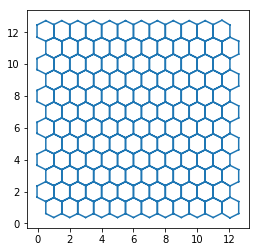

In [198]:
fig, ax = plt.subplots()

x, y = sheet.coords
srce_x = sheet.edge_df['s'+x].values
srce_y = sheet.edge_df['s'+y].values
trgt_x = sheet.edge_df['t'+x].values
trgt_y = sheet.edge_df['t'+y].values

lines_x, lines_y = np.zeros(2 * sheet.Ne), np.zeros(2 * sheet.Ne)
lines_x[::2] = srce_x
lines_x[1::2] = trgt_x
lines_y[::2] = srce_y
lines_y[1::2] = trgt_y
# Trick from https://github.com/matplotlib/
# matplotlib/blob/master/lib/matplotlib/tri/triplot.py#L65
lines_x = np.insert(lines_x, slice(None, None, 2), np.nan)
lines_y = np.insert(lines_y, slice(None, None, 2), np.nan)
ax.plot(lines_x, lines_y)
ax.set_aspect('equal')


In [153]:
sheet.vert_df.loc[[86, 84, 38]]

,x,y,z,is_active,rho,height,basal_shift
vert,,,,,,,
86,-0.05,0.350,0.0,1,0.0,0.0,4.0
84,10.50,5.375,0.0,1,0.0,0.0,4.0
38,2.50,10.625,0.0,1,0.0,0.0,4.0


,face,srce,trgt,sx,tx,sy,ty,dx,dy,dz,nx,ny,nz,length,is_valid,at_x_boundary,at_y_boundary,sub_area
edge,,,,,,,,,,,,,,,,,,
0,13,88,37,0.5,1.0,0.625,0.375,0.5,-0.25,0.0,0.0,0.0,1.0,0.559017,True,False,False,0.5
1,13,37,87,1.0,1.5,0.375,0.625,0.5,0.25,0.0,0.0,0.0,1.0,0.559017,True,False,False,0.5
2,13,87,20,1.5,1.5,0.625,1.375,0.0,0.75,0.0,0.0,0.0,1.0,0.750000,True,False,False,0.5
3,13,20,93,1.5,1.0,1.375,1.625,-0.5,0.25,0.0,0.0,0.0,1.0,0.559017,True,False,False,0.5
4,13,93,3,1.0,0.5,1.625,1.375,-0.5,-0.25,0.0,0.0,0.0,1.0,0.559017,True,False,False,0.5


(array([506.,  22.,  48.,   0.,   0.,  20.,   0., 220.,   4.,  44.]),
 array([0.54922936, 0.57544279, 0.60165622, 0.62786964, 0.65408307,
        0.6802965 , 0.70650993, 0.73272335, 0.75893678, 0.78515021,
        0.81136364]),
 <a list of 10 Patch objects>)

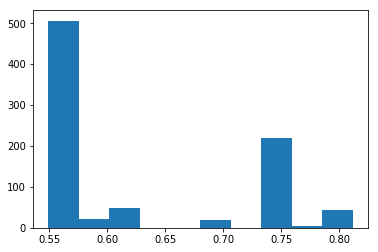

In [134]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.hist((sheet.edge_df.dx**2+sheet.edge_df.dy**2)**0.5)